In [1]:
import utils, data, simulation
import os
import os.path as op
import pandas as pd
import numpy as  np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
checkAxon = True
drawAllDist = False

In [3]:
#where the data is
datapath = os.environ['VISCOG_DATA']
#folder containing scripts
scriptpath = os.environ['SCRIPT_DATA']
outpath = op.join(scriptpath, 'data')
filename = 'S_12-005_12-104_13-101__collated_both_sessions.csv'


data = data.processing()
(double_x2, catch, subjectdata) = data.get_two_point(outpath, scriptpath, filename)

In [4]:
simulations = simulation.get_sims(subjectdata)
subjects = subjectdata.index

In [5]:
subjectdata

,implant_rot,implant_type,implant_type_str,implant_x,implant_y,loc_od_x,loc_od_y,viscog_subject_id,xmax,xmin,ymax,ymin,eye,session,rho,lambda,scale
subject_id,,,,,,,,,,,,,,,,,
12-005,-0.49500,<class 'pulse2percept.implants.ArgusII'>,ArgusII,-1331.0000,-850.0000,16.200000,1.380000,NaN,30.0,-30.0,22.5,-22.5,RE,2019_05_29,315.00,500.0,0.5
12-104,-0.35500,<class 'pulse2percept.implants.ArgusII'>,ArgusII,-515.0000,108.0000,18.500000,2.620000,NaN,30.0,-30.0,22.5,-22.5,RE,2019_05_30,1887.69,10.0,0.5
13-101,-0.67358,<class 'pulse2percept.implants.ArgusII'>,ArgusII,-965.1227,429.0195,15.055678,1.821214,NaN,30.0,-30.0,22.5,-22.5,RE,2019_05_31,1127.00,717.0,0.5


## Median Split Data

In [6]:
def get_mean_amp(row):
    return np.mean([int(row['pts_amp1']),int(row['pts_amp2'])])
double_x2['mean_amplitude'] = double_x2. apply(get_mean_amp, axis =1)
# 1 if they report 2 shapes, 0 if they report anything else    
double_x2['prob_2'] =double_x2.apply(utils.convert_prob, axis=1)

In [7]:
double_x2['electrode_pair'] = double_x2.apply(utils.combine_electrodes, axis=1)
double_x2['electrode_distance'] = double_x2.apply(utils.get_distance, simulations = simulations, axis=1)

In [8]:
if checkAxon:
    axonal_calc_bi = double_x2.apply(utils.get_axonal_distances, model_type = 'bidirectional',simulations = simulations, axis =1)
    double_x2[['dta_bi', 'daa_bi']] = axonal_calc_bi[['distance_to_axon', 'distance_along_axon']]


In [9]:
def median_split(data, median_var):

    # divides dataset through the median

    # of a variable of interest,

    # returns two DataFrames (smaller than median, larger than median)

    data = data.sort_values(by= median_var)

    median = data[median_var].median()

    return data[data[median_var]<=median], data[data[median_var]>median]


   

subject_id=="12-005"
subject_id=="12-104"
subject_id=="13-101"


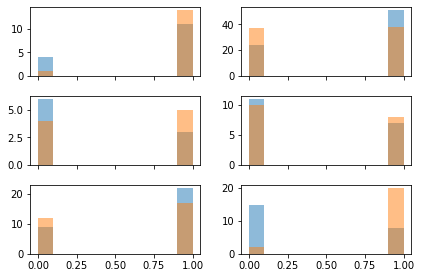

In [10]:
from statsmodels.stats.proportion import proportion_confint as confint
splits_val = pd.DataFrame()
i = 0
j= 0 
method = 'wilson'

fig,ax = plt.subplots(3,2, sharex=True)
fig.tight_layout(pad=1 )

for subject in subjects:
    j = 0
    query_string = 'subject_id==' + '"' + subject + '"'
    print(query_string)  
    #select subject
    split = double_x2.query(query_string)
    #split their data into sessions
    split_sessions =  [x for _, x in split.groupby(split['date'])]
    #for each session 
    for session in split_sessions:
        #do a median split
        low, high = median_split(session,'index')
        
        
        #calculate prob of seeing 2 i.e. mean of col prob 2
        splits_val = splits_val.append( {'subject_id': subject,'session': j, 'half': 1, 'prob_2': np.mean(low['prob_2']),
                                 'std_dev' : np.std(low['prob_2'], ddof= 1), 
                                 'std_err': np.std(low['prob_2'], ddof= 1)/  np.sqrt(np.size(low['prob_2'])), 
                                '95ci': np.round(confint(np.sum(low['prob_2']), len(low['prob_2']), method= method),2),
                                        'unique electrodes': np.sort(np.union1d(low.pts_electrode1.unique(), low.pts_electrode2.unique())),
                                        'unique electrode-pairs': np.sort(low.electrode_pair.unique()),
                                         'max distance between pairs': low.electrode_distance.max(),
                                        'n': len(low)}, 
                                 ignore_index= True, sort=False)
        splits_val =splits_val.append( {'subject_id': subject,'session': j, 'half': 2, 'prob_2': np.mean(high['prob_2']), 
                                'std_dev' : np.std(high['prob_2'], ddof= 1), 
                                'std_err': np.std(high['prob_2'], ddof= 1)/  np.sqrt(np.size(high['prob_2'])),
                                  '95ci': np.round(confint(np.sum(high['prob_2']), len(high['prob_2']), method= method),2),  
                                'unique electrodes': np.sort(np.union1d(high.pts_electrode1.unique(), high.pts_electrode2.unique())),
                                    'unique electrode-pairs': np.sort(low.electrode_pair.unique()),
                                        'max distance between pairs': high.electrode_distance.max(), 'n': len(high)}, 
                                  ignore_index= True,sort=False)


        lplot = ax[i,j].hist(low['prob_2'], alpha=0.5, label = 'First Half')
        hplot = ax[i,j].hist(high['prob_2'], alpha=0.5, label = 'Second Half')        
        j += 1 
    i += 1 


In [11]:
import numpy as np
import sys
np.set_printoptions(threshold=sys.maxsize)

In [12]:
from math import comb

In [13]:
pair_compare = splits_val[['subject_id', 'session', 'half','unique electrode-pairs','unique electrodes']]

In [14]:
pair_compare['n(pair)']= pair_compare['unique electrode-pairs'].str.len()


<ipython-input-14-e0755914a227>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pair_compare['n(pair)']= pair_compare['unique electrode-pairs'].str.len()


In [15]:
pair_compare

,subject_id,session,half,unique electrode-pairs,unique electrodes,n(pair)
0,12-005,0.0,1.0,"[A4-A8, A4-E10, A4-F2, A8-D1, A8-E10, A8-F2, D...","[A4, A8, D1, E10, F2]",9
1,12-005,0.0,2.0,"[A4-A8, A4-E10, A4-F2, A8-D1, A8-E10, A8-F2, D...","[A4, A8, D1, E10, F2]",9
2,12-005,1.0,1.0,"[A2-A4, A2-A8, A2-B3, A2-D1, A2-D8, A2-E10, A2...","[A2, A4, A8, B3, B6, D1, D8, E10, E3, F2, F7]",45
3,12-005,1.0,2.0,"[A2-A4, A2-A8, A2-B3, A2-D1, A2-D8, A2-E10, A2...","[A2, A4, A8, B3, B6, D1, D8, E10, E3, F2, F7]",45
4,12-104,0.0,1.0,"[B6-B9, B6-F7, B6-F9, B9-F7, F7-F9]","[B6, B9, F7, F9]",5
5,12-104,0.0,2.0,"[B6-B9, B6-F7, B6-F9, B9-F7, F7-F9]","[B6, B9, F7, F9]",5
6,12-104,1.0,1.0,"[A10-B10, A10-B5, A10-F7, B10-B5, B10-F7, B5-F...","[A10, B10, B5, B6, B9, F7, F9]",10
7,12-104,1.0,2.0,"[A10-B10, A10-B5, A10-F7, B10-B5, B10-F7, B5-F...","[A10, B10, B5, B6, B9, F7, F9]",10
8,13-101,0.0,1.0,"[A8-C8, A8-D6, B10-B4, B10-C6, B10-E9, B10-F10...","[A8, B10, B4, C6, C8, C9, D6, E9, F10]",17
9,13-101,0.0,2.0,"[A8-C8, A8-D6, B10-B4, B10-C6, B10-E9, B10-F10...","[A8, B10, B4, C6, C8, C9, D6, E9, F10]",17


In [16]:
fname = 'possible_pairs.csv'
pair_compare.to_csv(op.join(outpath,  fname))

In [18]:
# reorganized columns
splits_val.iloc[:,[8,5,1,4,0,6,7]]

,subject_id,session,half,prob_2,95ci,std_dev,std_err
0,12-005,0.0,1.0,0.733333,"[0.48, 0.89]",0.457738,0.118187
1,12-005,0.0,2.0,0.933333,"[0.7, 0.99]",0.258199,0.066667
2,12-005,1.0,1.0,0.680000,"[0.57, 0.77]",0.469617,0.054227
3,12-005,1.0,2.0,0.506667,"[0.4, 0.62]",0.503322,0.058119
4,12-104,0.0,1.0,0.333333,"[0.12, 0.65]",0.500000,0.166667
5,12-104,0.0,2.0,0.555556,"[0.27, 0.81]",0.527046,0.175682
6,12-104,1.0,1.0,0.388889,"[0.2, 0.61]",0.501631,0.118236
7,12-104,1.0,2.0,0.444444,"[0.25, 0.66]",0.511310,0.120517
8,13-101,0.0,1.0,0.709677,"[0.53, 0.84]",0.461414,0.082872
9,13-101,0.0,2.0,0.586207,"[0.41, 0.74]",0.501230,0.093076


### 